# This notebook contains preliminary results

In [13]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess import sentence_level_pause_correction, remap_English_MJFF_participant_ids
from haberrspd.plotting import plot_roc_curve_simple
import pandas as pd
import numpy as np


# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Naive modelling

In [4]:
# Load data
df = pd.read_csv(data_root / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'EnglishParticipantKey.csv',
                      index_col=0,
                      header=0,
                      names=['participant_id','test1','test2', 'diagnosis'])
df_meta.drop(columns=['test1','test2'],inplace=True)

### Create dataset

In [5]:
# Drop too short sentences
char_count_response_threshold=40
df = df[df.groupby(['participant_id', 'sentence_id']).key.transform('count') > char_count_response_threshold]

# Corrected compression times (i.e. timestamp difference / delta)
corrected_compression_times = sentence_level_pause_correction(df)

### Extract summary statistics and use these as features in a vanilla classifier

In [6]:
data = []
for sent_idx in corrected_compression_times.keys():
    for participant in corrected_compression_times[sent_idx]:
        tmp = corrected_compression_times[sent_idx][participant][1:]
        # Append to list which we'll pass to a dataframe in subsequent cells
        data.append((participant, sent_idx, 
                    int(df_meta.loc[participant]),
                    tmp.mean(), tmp.var()))
col_names =  ['Patient_ID', 'Sentence_ID', 'Diagnosis', 'Mean_IKI', 'Var_IKI']
df_summary_stats  = remap_English_MJFF_participant_ids(pd.DataFrame(data, columns = col_names))

In [7]:
df_summary_stats.head()

,Patient_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI
0,10,55,0,180.018290,25674.455362
1,10,55,0,170.727941,25817.206917
2,11,55,0,272.838028,68851.484217
3,11,55,0,236.960000,35109.917852
4,12,55,0,427.287315,117193.241209


In [8]:
df_summary_stats.dropna(inplace=True)
df_summary_stats.isnull().values.any()

False

### Baseline classification

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC


X = df_summary_stats.iloc[:,[3]].to_numpy()
y = df_summary_stats.Diagnosis.to_numpy()
# We use 10% of our data for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
clf = SVC(class_weight='balanced',gamma='auto', probability=True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
y_probas = clf.predict_proba(X_test)

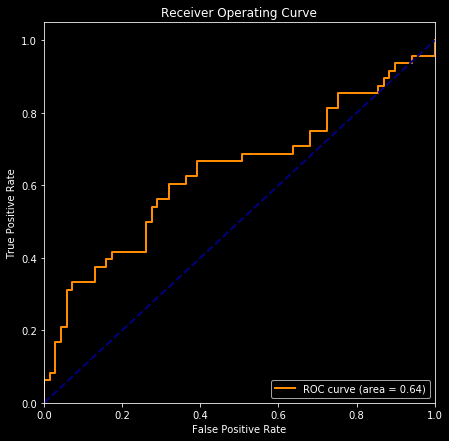

In [16]:
plot_roc_curve_simple(y_test,y_probas[:,1])

# Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [67]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



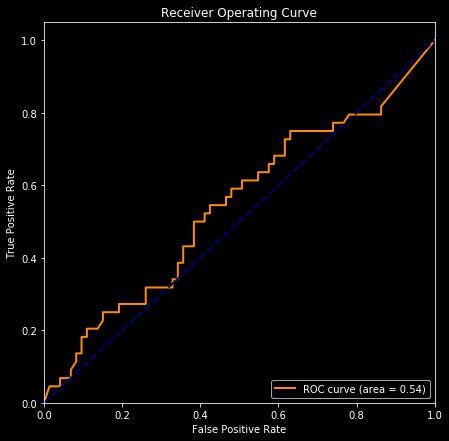

Number of hyperparameter permutations considered: 200



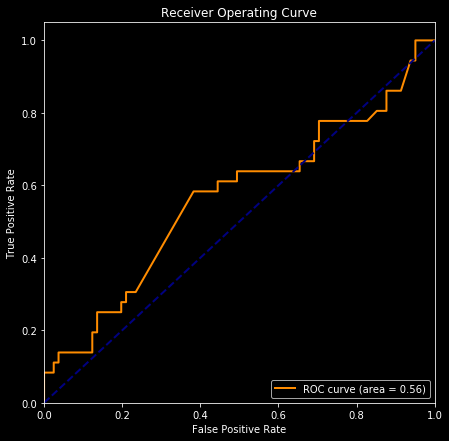

Number of hyperparameter permutations considered: 500



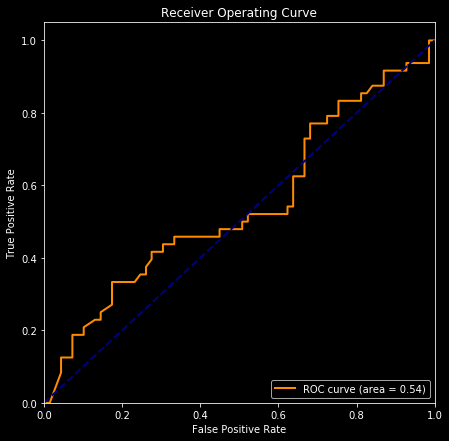

In [68]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

# CHARACTERS and TIME

In [50]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



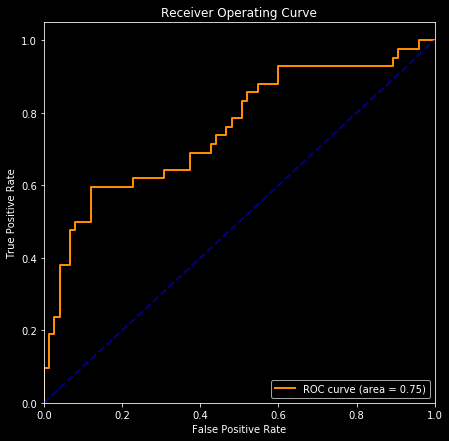

Number of hyperparameter permutations considered: 200



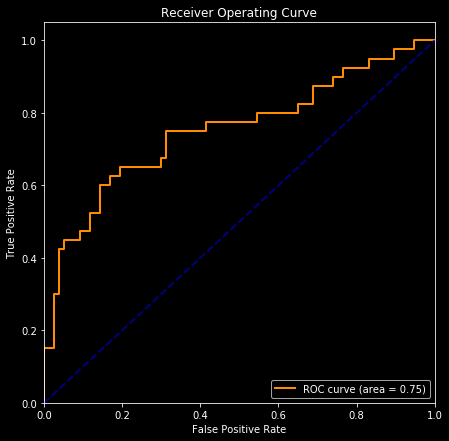

Number of hyperparameter permutations considered: 500



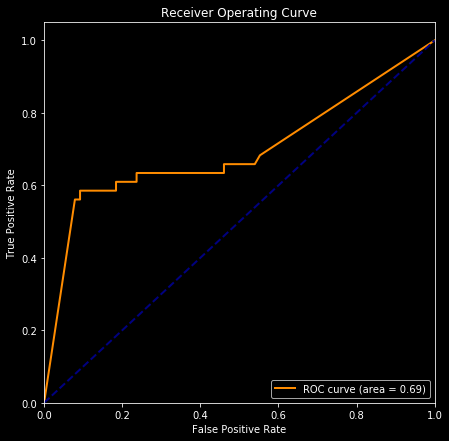

In [51]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

# CHARACTERS and TIME and Space

In [43]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}


Number of hyperparameter permutations considered: 100



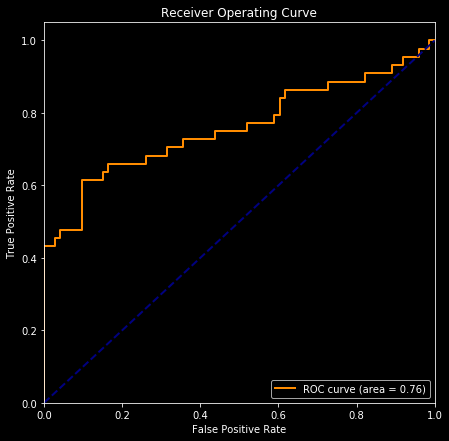


Number of hyperparameter permutations considered: 500



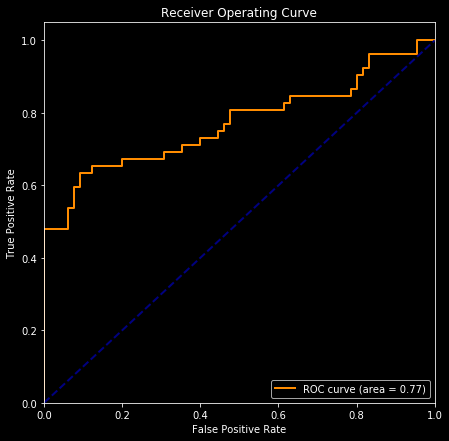

In [49]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [54]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [57]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

,round_epochs,val_loss,val_acc,loss,acc,alphabet_size,batch_size,control_class_weight,conv_activation,conv_bias_initializer,...,last_activation,loss.1,lr,max_sentence_length,number_of_large_filters,number_of_small_filters,optimizer,pd_class_weight,pool_length,small_filter_length
387,8,0.086684,0.786325,0.093786,0.721640,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,1,<class 'keras.optimizers.Adam'>,1.402406,2,20
326,13,0.560294,0.777778,0.469171,0.789323,51,32,0.777037,relu,uniform,...,sigmoid,binary_crossentropy,2.08,14000,2,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
126,13,0.088169,0.777778,0.083724,0.763584,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,2.08,14000,1,4,<class 'keras.optimizers.Adam'>,1.402406,2,5
448,16,0.086703,0.777778,0.071692,0.789323,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,1,<class 'keras.optimizers.Nadam'>,1.402406,2,20
248,7,0.089374,0.777778,0.103207,0.716873,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,4.06,14000,2,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
201,11,0.079817,0.777778,0.087058,0.747378,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,2,<class 'keras.optimizers.Nadam'>,1.402406,2,20
404,15,0.084064,0.769231,0.093846,0.751192,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,2.08,14000,4,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
460,16,0.079845,0.769231,0.073406,0.779790,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,2,<class 'keras.optimizers.Nadam'>,1.402406,2,20
165,19,0.086417,0.769231,0.092666,0.753098,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,4,<class 'keras.optimizers.Nadam'>,1.402406,2,10
74,20,0.080932,0.769231,0.075629,0.777884,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,2,1,<class 'keras.optimizers.Adam'>,1.402406,2,10


In [62]:
# Detailed look at the "winning model"
df.iloc[387,:]

round_epochs                                              8
val_loss                                          0.0866844
val_acc                                            0.786325
loss                                              0.0937864
acc                                                 0.72164
alphabet_size                                            51
batch_size                                               16
control_class_weight                               0.777037
conv_activation                                        relu
conv_bias_initializer                               uniform
conv_kernel_initializer                             uniform
conv_output_space                                        16
dense_activation                                       relu
dense_bias_initializer                              uniform
dense_kernel_initializer                            uniform
dense_units_layer_2                                      32
dense_units_layer_3                     